In [1]:
%matplotlib inline

#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
from matplotlib.lines import Line2D
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module


In [2]:
df = pd.read_csv('../../datasets/superstore.csv')

In [3]:
technology = df.loc[df['Category'] == 'Technology']
technology

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,8/27/2014,9/1/2014,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,1/16/2016,1/20/2016,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,12/8/2016,12/10/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,9984,US-2016-157728,9/22/2016,9/28/2016,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,TEC-PH-10001305,Technology,Phones,Panasonic KX TS208W Corded phone,97.980,2,0.0,27.4344
9986,9987,CA-2016-125794,9/29/2016,10/3/2016,Standard Class,ML-17410,Maris LaWare,Consumer,United States,Los Angeles,...,90008,West,TEC-AC-10003399,Technology,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.240,1,0.0,15.2208
9987,9988,CA-2017-163629,11/17/2017,11/21/2017,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-AC-10001539,Technology,Accessories,Logitech G430 Surround Sound Gaming Headset wi...,79.990,1,0.0,28.7964
9988,9989,CA-2017-163629,11/17/2017,11/21/2017,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-PH-10004006,Technology,Phones,Panasonic KX - TS880B Telephone,206.100,5,0.0,55.6470


In [4]:
technology['Order Date'].min(), technology['Order Date'].max()

('1/10/2016', '9/9/2017')

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
technology.drop(cols, axis=1, inplace=True)
technology.isnull().sum()


C:\Users\Nasuha.Imanina\anaconda3\envs\time-series-labs\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Order Date    0
Sales         0
dtype: int64

In [6]:
technology['Order Date'] = pd.to_datetime(technology['Order Date'])
technology.set_index('Order Date', inplace=True)


C:\Users\Nasuha.Imanina\anaconda3\envs\time-series-labs\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
technology

,Order Date,Sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


In [8]:
technology = technology.set_index('Order Date')
technology.index


DatetimeIndex(['2014-01-06', '2014-01-09', '2014-01-13', '2014-01-15',
               '2014-01-16', '2014-01-20', '2014-01-26', '2014-02-01',
               '2014-02-02', '2014-02-06',
               ...
               '2017-12-18', '2017-12-21', '2017-12-22', '2017-12-23',
               '2017-12-24', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=824, freq=None)

In [41]:
y = technology['Sales'].resample('MS').mean()
y.shape

(48,)

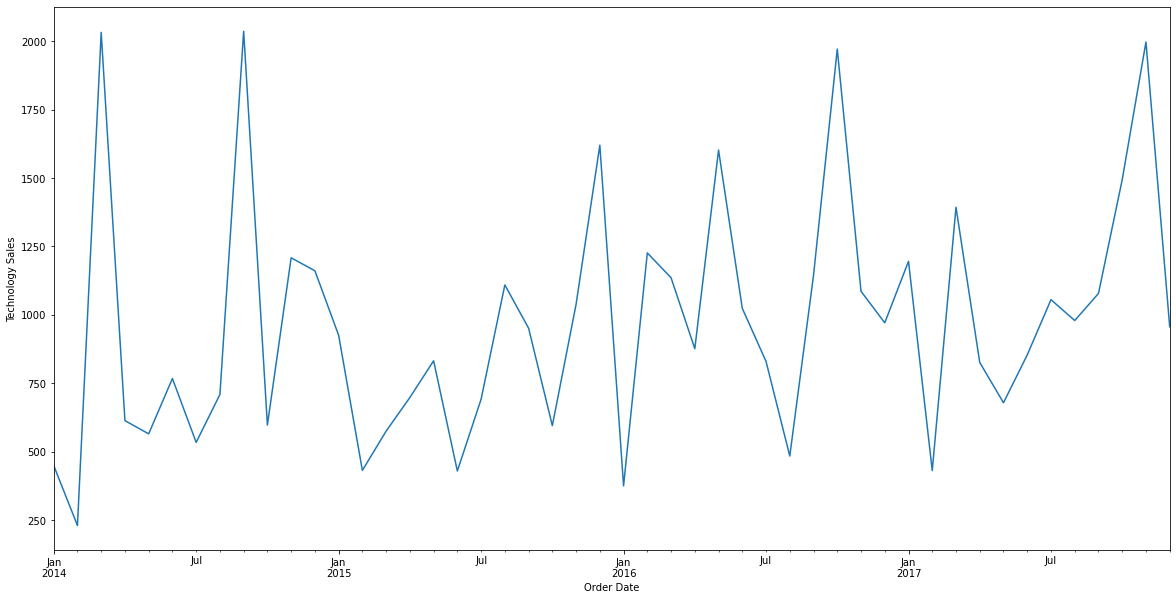

In [10]:
y.plot(figsize=(20,10))
plt.xlabel("Order Date")
plt.ylabel("Technology Sales")
plt.show()

In [11]:
split_ratio = 0.7
num_epochs = 60
window_size = 2
batch_size = 2
n_step = 2


In [12]:
split_data = round(len(y)*split_ratio)
split_data

34

In [13]:
#split data by indexing 
train_data = y[:split_data]
test_data = y[split_data:]

train_time = y.index[:split_data]
test_time = y.index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(34,)
test_data_shape
(14,)


In [14]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data of train data to apply in test data.
scaler = StandardScaler().fit(train_data.values.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.values.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.values.reshape(-1, 1))

In [15]:
print(f"train_data_standard shape : {train_data_standard.shape}")
print(f"test_data_standard shape : {test_data_standard.shape}")

train_data_standard shape : (34, 1)
test_data_standard shape : (14, 1)


In [16]:
### BEGIN SOLUTION
trainX ,trainY =  data_module.univariate_multi_step(train_data_standard,window_size,n_step)
testX , testY = data_module.univariate_multi_step(test_data_standard,window_size,n_step)
### END SOLUTION
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(31, 2, 1) trainY shape:(31, 2, 1)

testX shape:(11, 2, 1) testY shape:(11, 2, 1)


In [17]:
def key_assign(trainingX,testingX,trainingY,testingY):
    """ 
    Use to assign  the key to create the train_data_dict and test_data_dict
    
    Arguments:
    trainingX -- feature for traning data 
    testingX -- feature for testing data
    trainingY -- label for traning data
    testingY -- label for testing data
    
    Returns: 
    train_data_dict -- dictionary of trainingX and trainingY
    test_data_dict -- dictionary of testingX and testingY
    """
    ### BEGIN SOLUTION
    
    # Create a dictionary that can store the train set feature and label
    train_data_dict = {"train_data_x_feature" : trainingX, "train_data_y_label" : trainingY}
    
    # Create a dictionary that can store the test set feature and label
    test_data_dict  = {"test_data_x_feature" : testingX , "test_data_y_label" : testingY }
    
    ### END SOLUTION
    return train_data_dict , test_data_dict

train_data_dictionary , test_data_dictionary = key_assign(trainingX = trainX,
                                 testingX = testX,
                                 trainingY = trainY,
                                 testingY = testY)


In [18]:
def transform(train_data_dict, test_data_dict):
    """ 
    Transform the NumPy data to torch tensor
    
    Arguments:
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary
    
    Returns: 
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary
    """
    ### BEGIN SOLUTION
    for train_datapoint in train_data_dict:
        train_data_dict[train_datapoint] =  torch.from_numpy(train_data_dict[train_datapoint]).type(torch.Tensor)
        
    for test_datapoint in test_data_dict:
        test_data_dict[test_datapoint] = torch.from_numpy(test_data_dict[test_datapoint]).type(torch.Tensor)
        
    ### END SOLUTION

    return train_data_dict,test_data_dict

train_data_dictionary,test_data_dictionary = transform(train_data_dictionary,test_data_dictionary)

In [19]:
def sanity_check(data_1,data_2):
    """ 
    Print the shape of data_1 and data_2
    
    Arguments:
    data_1 -- (dict) type of data
    data_2 -- (dict) type of data 
    """
    
    ### BEGIN SOLUTION

    for key_1 in data_1:
        print(key_1 +" shape : " + str(data_1[key_1].shape))
    for key_2 in data_2:
        print(key_2 +" shape : " + str(data_2[key_2].shape))
        
    ### END SOLUTION
# Sanity check
sanity_check(train_data_dictionary,test_data_dictionary)

train_data_x_feature shape : torch.Size([31, 2, 1])
train_data_y_label shape : torch.Size([31, 2, 1])
test_data_x_feature shape : torch.Size([11, 2, 1])
test_data_y_label shape : torch.Size([11, 2, 1])


In [20]:
# Create Iterator
def iterator(train_data_dict,test_data_dict,batch_size):
    """ 
    Create iterator for train data and test data 
    
    Arguments:
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary
    
    Returns: 
    train_iter -- train data iterator 
    test_iter -- test data iterator 
    """
    ### BEGIN SOLUTION
    train_dataset = TensorDataset(train_data_dict["train_data_x_feature" ],
                                  train_data_dict["train_data_y_label"])
    train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

    test_dataset = TensorDataset(test_data_dict["test_data_x_feature"],
                                 test_data_dict["test_data_y_label"])
    test_iter = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    ### END SOLUTION
    
    return train_iter , test_iter

train_iter , test_iter = iterator(train_data_dictionary,test_data_dictionary,batch_size)

In [21]:
# seed
torch.manual_seed(123)

#Arguments for LSTM model
hidden_dim = 1
n_feature = 1 
n_step = 2

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1


### BEGIN SOLUTION
#Vanila , Stacked LSTM
model = deep_learning_module.LSTM(n_feature = n_feature ,
                         hidden_dim = hidden_dim ,
                         num_layers = num_layers,
                         n_step = n_step)
#Bidirectional LSTM
# model = deep_learning_module.BidirectionalLSTM(n_feature = n_feature ,
#                          hidden_dim = hidden_dim ,
#                          num_layers = num_layers,
#                          n_step = n_step)
### END SOLUTION

In [22]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#dropout
# dropout = nn.Dropout()

In [23]:
inputs = torch.zeros((batch_size,window_size,1),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs))

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -    [2, 2, 1]      16          8
1_fc         [1, 2]       [2, 2]       4          2
---------------------------------------------------
                      Totals
Total params              20
Trainable params          20
Non-trainable params       0
Mult-Adds                 10
       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -    [2, 2, 1]      16          8
1_fc         [1, 2]       [2, 2]       4          2


In [24]:
# Start Training 
torch.manual_seed(123)
train_loss,val_loss = deep_learning_module.training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model)

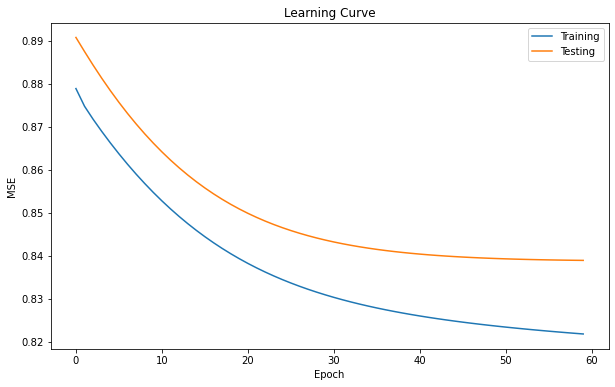

Epoch : 0 , training loss : 0.8788716312377683 , validation loss : 0.8907578695904125
Epoch : 1 , training loss : 0.8747560189616296 , validation loss : 0.8874820917844772
Epoch : 2 , training loss : 0.871727547337932 , validation loss : 0.8843088678338311
Epoch : 3 , training loss : 0.8689125997404898 , validation loss : 0.8812784268097444
Epoch : 4 , training loss : 0.866240200496489 , validation loss : 0.8783984238451178
Epoch : 5 , training loss : 0.8636963348234853 , validation loss : 0.8756685135039416
Epoch : 6 , training loss : 0.8612757325172424 , validation loss : 0.8730859011411667
Epoch : 7 , training loss : 0.8589745990691646 , validation loss : 0.8706468885595148
Epoch : 8 , training loss : 0.8567892389912759 , validation loss : 0.868347289210016
Epoch : 9 , training loss : 0.8547160221684363 , validation loss : 0.8661824275146831
Epoch : 10 , training loss : 0.8527510920839925 , validation loss : 0.8641478297385302
Epoch : 11 , training loss : 0.8508907402715375 , valida

In [25]:
data_module.learning_curve(num_epochs,train_loss,val_loss)

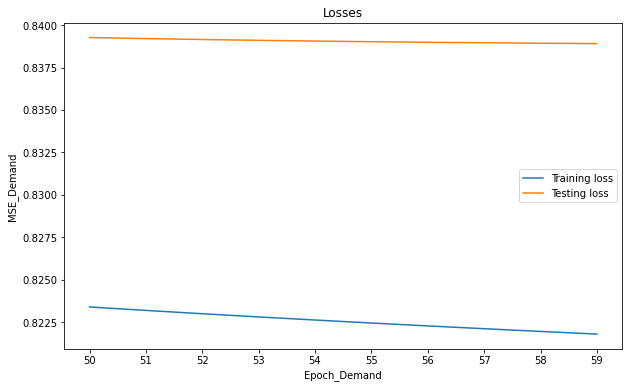

In [26]:
data_module.zoom_learning_curve(start_epoch = 50,
                                end_epoch =60,
                                training_loss = train_loss,
                                validation_loss = val_loss)

In [27]:
# Section 1 : Feed in the train and test data to the model
with torch.no_grad():
    y_train_prediction = model(train_data_dictionary["train_data_x_feature"])
    y_test_prediction = model(test_data_dictionary["test_data_x_feature"])
    

In [28]:
def key_assign_evaluation(y_train_prediction,
                          y_test_prediction,
                          train_data_dictionary,
                          test_data_dictionary):
    """ 
    Assign key for prediction and output data dictionary 
    
    Arguments:
    y_train_prediction -- (tensor) prediction for training data
    y_test_prediction -- (tensor) prediction for test data
    train_data_dictionary -- (dict) train data dictionary
    test_data_dictionary -- (dict) test data dictionary
    
    
    Returns: 
    prediction -- (dict) dictionary that consists of prediction from train data and test data
    output_data -- (dict) dictionary that consists of output(label) from train data and test data
    """
    ### BEGIN SOLUTION
    prediction ={"train_data_prediction" : y_train_prediction,
            "test_data_prediction" :y_test_prediction }
    output_data ={"train_data_output" : train_data_dictionary["train_data_y_label"] ,
               "test_data_output" : test_data_dictionary["test_data_y_label"]}
    ### END SOLUTION
    return prediction , output_data

prediction , output_data = key_assign_evaluation(y_train_prediction,y_test_prediction,
                                                 train_data_dictionary,
                                                 test_data_dictionary)     

In [29]:
# Check the prediction and output shape
sanity_check(data_1 = prediction,data_2 = output_data)

train_data_prediction shape : torch.Size([31, 2])
test_data_prediction shape : torch.Size([11, 2])
train_data_output shape : torch.Size([31, 2, 1])
test_data_output shape : torch.Size([11, 2, 1])


In [30]:
# Section 2 : Reshape both to the original data dimension
def squeeze_dimension(output):
    """ 
    Squeeze the dimension of output data
    
    Arguments:
    output -- (dict) output_data
    
    Returns: 
    output_data -- (dict) output_data
    """
    ### BEGIN SOLUTION
    for key in output:
        output[key] = torch.squeeze(output[key],2)
    ### END SOLUTION
    return output

output_data = squeeze_dimension(output_data)

In [31]:
# Check the output shape
sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([31, 2])
test_data_output shape : torch.Size([11, 2])


In [32]:
# Section 3 : Invert the scaling back to orignal data value
def inverse_scaler(scaled_data,scaler):
    """ 
    Inverse the scaled data
    
    Arguments:
    scaled_data -- (dict) data that being scaled 
    scaler -- scaler 
    
    Returns: 
    scaled_data -- (dict) data after inverse scale
    """
    ### BEGIN SOLUTION
    for item in scaled_data:
        scaled_data[item] =  scaler.inverse_transform(scaled_data[item].detach().numpy())
    ### END SOLUTION
    return scaled_data
    
prediction = inverse_scaler(prediction,scaler)
output_data  = inverse_scaler(output_data ,scaler)


In [33]:
sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (31, 2)
test_data_prediction shape : (11, 2)
train_data_output shape : (31, 2)
test_data_output shape : (11, 2)


In [34]:
def list_forecast_value(output_data,prediction):
    """ 
    To list the test output and prediction output side by side
    
    Arguments:
    output_data --  (dict) output data dictionary
    prediction -- (dict) prediction output dictionary
    """
    ### BEGIN SOLUTION
    print("Test Data\t\t\tForecast")
    for test, forecast in zip(output_data["test_data_output"],prediction["test_data_prediction"]):   
        print(f"{test}\t\t{forecast}")
    ### END SOLUTION
        
list_forecast_value(output_data,prediction)        

Test Data			Forecast
[1195.218   430.5017]		[936.3065  962.47577]
[ 430.5017 1392.8593]		[934.65283 964.0269 ]
[1392.8593   825.55914]		[934.33984 964.32043]
[825.55914 678.3294 ]		[937.98114 960.905  ]
[678.3294 853.055 ]		[932.40155 966.13855]
[ 853.055  1054.9966]		[942.43365 956.7287 ]
[1054.9966   978.84235]		[944.0974  955.16815]
[ 978.84235 1077.7041 ]		[939.20605 959.7561 ]
[1077.7041 1493.4392]		[936.75354 962.0565 ]
[1493.4392 1996.7509]		[936.6449 962.1584]
[1996.7509   955.86566]		[925.9594 972.181 ]


In [35]:
# Section 4 : Calculate the RMSE of train and test data
def rmse(prediction,output_data):
    """ 
    Calculate RMSE between output data and prediction data 
    
    Arguments:
    prediction -- (dict) prediction output dictionary
    output_data --  (dict) output data dictionary
    
    Returns:
    trainScore - RMSE of train dataset
    testScore - RMSE of test dataset
    """
    trainScore = math.sqrt(mean_squared_error(prediction["train_data_prediction"], output_data["train_data_output"]))
    testScore = math.sqrt(mean_squared_error(prediction["test_data_prediction"], output_data["test_data_output"]))
    return trainScore,testScore

trainScore,testScore = rmse(prediction,output_data)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 425.23 RMSE
Test Score: 429.74 RMSE


In [36]:
plot_details ={"x-axis" : "Date",
          "y-axis" : "Values",
          "title"  : "Technology Sales"
         }

In [37]:
# Plot forecast plot for multi-step
def multi_step_plot(original_test_data,
                    after_sequence_test_data ,
                    forecast_data,test_time,window_size,
                    n_step ,
                    details = {},
                    original_plot = False):
    
    """ 
    Plot the result of the multi-step forecast 
    
    Arguments:
    
    original_test_data -- test data before sequence
    
    after_sequence_test_data -- (dict) output data dictionary
    
    forecast_data -- (dict) prediction data dictionary
    
    test_time --  time index for test data before sliding window (data sequence)
    
    window_size -- window size for the data sequence
    
    n_step -- the number of future step , 1 -> single >1 -> multi-step
    
    details -- (dict) details for plot such as "x-axis" ,"y-axis", "title"
    
    original_plot -- (boolean) True ->observe how sliding window (data sequence) take place in the test data
    
    """
    
    after_sequence_test_data = after_sequence_test_data['test_data_output'] 
    forecast_data = forecast_data["test_data_prediction"]
    
    # Plot Setting
    plt.figure(figsize=(10,6))
    plt.xticks(rotation=45)    
    
    # Store test and forecast data into DataFrame type 
    column_names = ["timestep_" + str(i) for i in range(after_sequence_test_data.shape[1])]
    y_test_dataframe = pd.DataFrame(after_sequence_test_data,columns = column_names)
    y_test_pred_dataframe =pd.DataFrame(forecast_data,columns = column_names)
    
    # Create time index for data after sequence
    time_index_after_sequence = test_time[window_size:]
    
    # Test Data plot before sliding window(data sequencing)
    if original_plot:
        plt.plot(test_time,original_test_data,marker='x',color="blue")

    # For loop to plot the data step by step base on time index    
    start_idx = 0 
    for row in range(len(y_test_dataframe)):
        
        # Iterate the time index after sequence
        time_index = time_index_after_sequence[start_idx:start_idx+n_step]
        
        # Plot the test data
        plt.plot(time_index,y_test_dataframe.iloc[row],color="green",marker='o')
        
        # Plot the forecast data
        plt.plot(time_index,y_test_pred_dataframe.iloc[row],color="red",marker='o')
        
        # Pointer for time_index_after_sequence
        start_idx += 1
        
    # Customize the legend
    custom_lines = [Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="blue", lw=4)]
    plt.legend(custom_lines, ['Test Data After Sequencing', 'Forecast Data', 'Test Data Before Sequencing'])
    
    # Extra details - Optional function
    if details != {}:
        plt.xlabel(details["x-axis"])
        plt.ylabel(details["y-axis"])
        plt.title(details["title"])
    

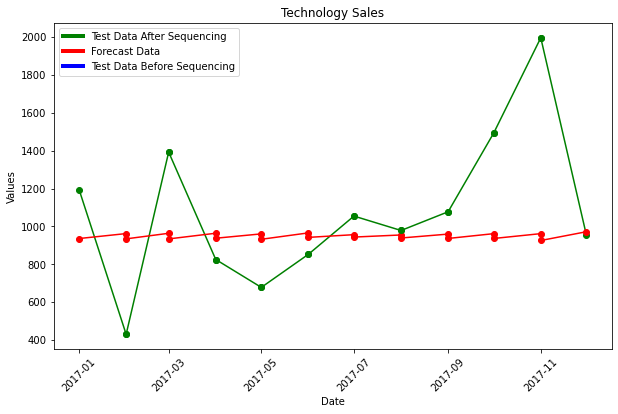

In [38]:
# Use the multi_step_plot function
multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = False)